In [855]:
import numpy as np
import sys
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import utilities as utils 

onecol = 3.42
onep5 = 4.5
twocol = 7

ext = ".jpg"

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8
plt.rcParams['lines.linewidth'] = 1.5

color1 = (.6,.06,.06)
color2 = (.42,.6,.06)
color3 = (.15,.06,.6)

def rec(x):
    return (x + np.abs(x))/2

def v_std(f,meanax = 0,indices = [0,1],axis =-1):
    
    return np.take(np.std(f,axis = meanax),indices,axis)

def boot_f(func,f,bootax = 1,nboot = 1000):
    ind = [np.random.choice(range(f.shape[bootax]),f.shape[bootax]) for k in range(nboot)]

    rr = [func(np.take(f,ind[i],bootax)) for i in range(len(ind))]
    print(np.array(rr).shape)
    std = np.std(rr,0)
    
    return std

def resp_std(f,axis = -1,square = False,indices = [0,1],meanfirst = True,meanax = 0,nboot = 1000):
   
    ind = [np.random.choice(range(f.shape[meanax[0]]),f.shape[meanax[0]]) for k in range(nboot)]

    rr = [resp(np.take(f,ind[i],meanax[0]),axis,square,indices,meanfirst,meanax) for i in range(len(ind))]

    std = np.std(rr,0)
    
    return std

def resp(f,axis = -1,square = False,indices = [0,1],meanfirst = True,meanax = 0):
    if meanfirst:
        r = np.mean(f,axis = meanax,keepdims = True)
    else:
        r = np.copy(f)
    
    R = 0
    
    for i in indices:
        R += rec(np.take(r,i,axis = axis))**2
    
    R = np.mean(R,meanax)
    
    if square == False:
        R = np.sqrt(R)

    return R

def trans(x):
    y = [a for a in x]
    y[-1] = .2
    return tuple(y)

def fill_between(ax,x,mean,std,color):
    ax.fill_between(x,mean - std,mean + std,color = trans(color))

# GSM Figures
- Additivity Index at 2 values of SNR
- the rotated COS for noisy and noiseless 
- WTA plots for noisy and noiseless

(3, 500, 1, 60, 2)
(1000, 3, 20)
(1000, 3, 20, 3, 2)
(3, 20)
(3, 20, 3, 2)
(50, 1, 441, 2)


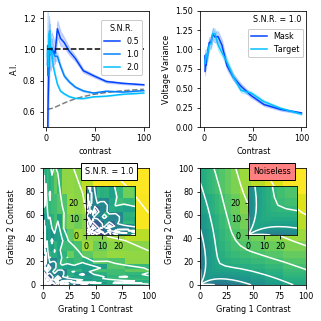

In [857]:
SNR = ["0.5","1.0","2.0"]

#Cross-Orientation suppression

noisy_COS_V = np.array([np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_{}_COS_1.0.pkl".format(snr))) for snr in SNR])
clean_COS_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_COS_1.0.pkl"))

print(noisy_COS_V.shape)

noisy_COS_response = np.reshape(resp(noisy_COS_V,meanax = (1,2)),[len(SNR),20,3])
clean_COS_response = np.reshape(resp(clean_COS_V,meanax = (0)),[20,3])

noisy_COS_std = np.reshape(v_std(noisy_COS_V,meanax = (1,2)),[len(SNR),20,3,2])
clean_COS_std = np.reshape(v_std(clean_COS_V,meanax = (0)),[20,3,2])

def AI(f):
    a = np.reshape(resp(f,meanax = (1,2)),[len(SNR),20,3])
    b = a[:,:,0]/(a[:,:,1] + a[:,:,2])
    return b

def VAR(f):
    return np.reshape(v_std(f,meanax = (1,2)),[len(SNR),20,3,2])**2

noisy_AI_std = boot_f(AI,noisy_COS_V)
noisy_var_std = boot_f(VAR,noisy_COS_V)

print(noisy_AI_std.shape)
c = np.logspace(0,2,20)

clean_AI = clean_COS_response[:,0]/(clean_COS_response[:,1] + clean_COS_response[:,2])
noisy_AI = noisy_COS_response[:,:,0]/(noisy_COS_response[:,:,1] + noisy_COS_response[:,:,2])

fig,sub = plt.subplots(2,2,figsize = (onep5,onep5))

sub[0,0].plot(c,clean_AI,"--",color = (0,0,0,.5))

colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(noisy_AI))]
for k in range(len(noisy_AI)):
    sub[0,0].plot(c,noisy_AI[k],color = colors[k],label = "{}".format(SNR[k]))
    sub[0,0].fill_between(c,noisy_AI[k] - noisy_AI_std[k],noisy_AI[k] + noisy_AI_std[k],color = trans(colors[k]))
    
sub[0,0].plot(c,np.ones_like(c),"k--")
    
sub[0,0].legend(loc = (.55,.45),framealpha = 1,title = "S.N.R.")

sub[0,0].set_xlabel("contrast")
sub[0,0].set_ylabel("A.I.")
sub[0,0].set_ylim([.5,1.25])
print(noisy_COS_std.shape)
sub[0,1].plot(c,noisy_COS_std[1,:,1,0]**2,color = colors[0],label = "Mask")
fill_between(sub[0,1],c,noisy_COS_std[1,:,1,0]**2,noisy_var_std[1,:,1,0],colors[0])

sub[0,1].plot(c,noisy_COS_std[1,:,2,0]**2,color = colors[-1],label = "Target")
fill_between(sub[0,1],c,noisy_COS_std[1,:,2,0]**2,noisy_var_std[1,:,2,0],colors[-1])
sub[0,1].text(.5,.9,"S.N.R. = {}".format(SNR[1]),transform=sub[0,1].transAxes)
sub[0,1].set_ylabel("Voltage Variance")
sub[0,1].set_xlabel("Contrast")
sub[0,1].set_ylim([0,1.5])
sub[0,1].legend(loc = (.45,.6),framealpha = 1)

noisy_COS_rot_V = np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_1.0_COS_rot_1.0.pkl"))
clean_COS_rot_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_COS_rot_1.0.pkl"))

print(noisy_COS_rot_V.shape)

def symm(x):
    return (x + x.T)/2

from scipy.ndimage.filters import gaussian_filter as gfilt

c = np.concatenate([[0],np.logspace(0,2,20)])
c2 = np.concatenate([[0],np.logspace(0,2,20)])

noisy_COS_rot_response = symm(np.reshape(resp(noisy_COS_rot_V,meanax = (0,1)),[21,21]))
clean_COS_rot_response = symm(np.reshape(resp(clean_COS_rot_V,meanax = (0)),[21,21]))

#noisy_COS_rot_response = gfilt(noisy_COS_rot_response,.75)
#clean_COS_rot_response = gfilt(clean_COS_rot_response,.75)

ln = np.linspace(np.min(noisy_COS_rot_response), np.max(noisy_COS_rot_response),10)
lc = np.linspace(np.min(clean_COS_rot_response), np.max(clean_COS_rot_response),10)

lcol = [(1,1,1,1) for x in np.linspace(1,.25,len(lc))]

sub[1,0].pcolor(c2,c2,noisy_COS_rot_response)
sub[1,0].contour(c2,c2,noisy_COS_rot_response,ln,colors = lcol)
sub[1,0].set_xlabel("Grating 1 Contrast")
sub[1,0].set_ylabel("Grating 2 Contrast")
sub[1,0].text(40,95,"S.N.R. = 1.0",bbox = {"edgecolor":(0,0,0,1),"facecolor":(1,1,1,1)})

sub[1,1].pcolor(c,c,clean_COS_rot_response)
sub[1,1].contour(c,c,clean_COS_rot_response,lc,colors = lcol)
sub[1,1].set_xlabel("Grating 1 Contrast")
sub[1,1].set_ylabel("Grating 2 Contrast")
sub[1,1].text(50,95,"Noiseless",bbox = {"edgecolor":(0,0,0,1),"facecolor":(1,.5,.5,1)})

dx = .23
dd = .15

subax = fig.add_axes([.5 - dx,.5 - dx,dd,dd])
ii = -1
subax.pcolor(c2[:ii],c2[:ii],noisy_COS_rot_response[:ii,:ii])
subax.contour(c2[:ii],c2[:ii],noisy_COS_rot_response[:ii,:ii],lc,colors = lcol)
subax.set_ylim([0,30])
subax.set_xlim([0,30])
subax.set_yticks([0,10,20])
subax.set_yticklabels(["0","10","20"])
subax.set_xticks([0,10,20])
subax.set_xticklabels(["0","10","20"])

subax = fig.add_axes([1 - dx,.5 - dx,dd,dd])
ii = -1
subax.pcolor(c[:ii],c[:ii],clean_COS_rot_response[:ii,:ii])#,lc,colors = lcol)
subax.contour(c[:ii],c[:ii],clean_COS_rot_response[:ii,:ii],lc,colors = lcol)
subax.set_ylim([0,30])
subax.set_xlim([0,30])
subax.set_yticks([0,10,20])
subax.set_yticklabels(["0","10","20"])
subax.set_xticks([0,10,20])
subax.set_xticklabels(["0","10","20"])


plt.tight_layout()
plt.show()

(50, 1, 240, 2)
200
(1000, 20, 6, 2)


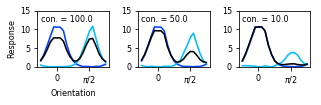

In [860]:
def rot90(x):
    y = np.concatenate([x,x[:1]])
    return np.roll(y,1+len(y)/4)
noisy_WTA_V = np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_1.5_WTA_1.0.pkl"))
clean_WTA_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_WTA_1.0.pkl"))

def WTA_resp(f,meanax,shape):
    return np.reshape(resp(f,meanax = meanax),shape)

print(noisy_WTA_V.shape)
print(2*20*5)
noisy_WTA = WTA_resp(noisy_WTA_V,meanax = (0,1),shape = [20,6,2])
clean_WTA = WTA_resp(clean_WTA_V,meanax = (0),shape = [20,6,2])

noisy_WTA_std = boot_f(lambda x:WTA_resp(x,0,[20,6,2]),noisy_WTA_V) 

a = np.linspace(0,np.pi,clean_WTA.shape[0]+1)

fig,sub = plt.subplots(1,3,figsize = (onep5,onep5/3))
cind = [-1,4,2]
c = ["0","5.0","10.0","25.0","50.0","100.0"]
for k in range(3):
    sub[k].plot(a,rot90(noisy_WTA[:,0,1]),color = (0,.25,1,1))
    sub[k].plot(a,rot90(noisy_WTA[:,cind[k],0]),color = (0,.75,1,1))
    sub[k].plot(a,rot90(noisy_WTA[:,cind[k],1]),"k")
    
    fill_between(sub[k],a,rot90(noisy_WTA[:,0,1]),rot90(noisy_WTA_std[:,0,1]),color = (0,.25,1,1))
    fill_between(sub[k],a,rot90(noisy_WTA[:,cind[k],0]),rot90(noisy_WTA_std[:,cind[k],0]),color = (0,.75,1,1))
    fill_between(sub[k],a,rot90(noisy_WTA[:,cind[k],1]),rot90(noisy_WTA_std[:,cind[k],1]),(0,0,0,1))

    
    sub[k].text(0,12,"con. = {}".format(c[cind[k]]),fontsize = 8)
    sub[k].set_xticks([np.pi/4,3*np.pi/4])
    sub[k].set_xticklabels(["0","$\pi/2$"])
    sub[k].set_ylim([0,15])

#     sub[1,k].plot(a,rot90(clean_WTA[:,0,1]),"r--")
#     sub[1,k].plot(a,rot90(clean_WTA[:,cind[k],0]),"b--")
#     sub[1,k].plot(a,rot90(clean_WTA[:,cind[k],1]),"k--")
#     sub[1,k].set_xticks([np.pi/4,3*np.pi/4])
#     sub[1,k].set_xticklabels(["0","$\pi/2$"])
#     sub[1,k].set_ylim([0,15])

sub[0].set_xlabel("Orientation")
sub[0].set_ylabel("Response")

plt.tight_layout()
plt.show()

(3, 50, 1, 441, 2)
(1, 120, 16)


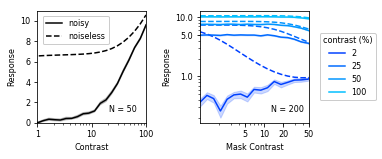

In [825]:
SNR = ["0.5","1.0","2.0"]

noisy_full_COS_V = np.array([np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_{}_full_COS_1.0.pkl".format(snr))) for snr in SNR])
clean_full_COS_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_full_COS_1.0.pkl"))

print(noisy_full_COS_V.shape)

N = noisy_full_COS_V.shape[1]

noisy_full_COS = np.reshape(resp(noisy_full_COS_V,meanax = (1,2)),[len(SNR),21,21])
noisy_full_COS_std = np.reshape(resp_std(noisy_full_COS_V,meanax = (1,2)),[len(SNR),21,21])
clean_full_COS = np.reshape(resp(clean_full_COS_V,meanax = (0)),[21,21])

c = np.concatenate([[0],np.logspace(0,2,20)])

fig,sub = plt.subplots(1,2,figsize = (onep5,onep5/2))

sub[0].plot(c,noisy_full_COS[0,0,:],"k",label = "noisy")
sub[0].fill_between(c,noisy_full_COS[0,0,:]-noisy_full_COS_std[0,0,:],noisy_full_COS[0,0,:] + noisy_full_COS_std[0,0,:],color = trans((0,0,0,1)))
sub[0].plot(c,clean_full_COS[0,:],"k--",label = "noiseless")
sub[0].set_ylim([0,11])
sub[0].set_xlim([1,100])
sub[0].set_xscale("log")
sub[0].set_xticks([1,10,100])
sub[0].set_xticklabels(["1","10","100"])
sub[0].set_xlabel("Contrast")
sub[0].set_ylabel("Response")
sub[0].text(.655,.1,"N = {}".format(N),backgroundcolor = (1,1,1,0),transform=sub[0].transAxes)
sub[0].legend(loc = (.05,.7),framealpha = 1)
##CARANDINI
carSNR = ["0.5","0.75","1.0","1.5","2.0"]

noisy_carandini_V = np.array([utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_{}_carandini_rep_1.0.pkl".format(s)) for s in carSNR])
clean_carandini_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_carandini_rep_1.0.pkl"))
N = noisy_carandini_V.shape[1]

print(clean_stiff_carandini_V.shape)
c = np.logspace(0,2,20)
noisy_carandini = np.reshape(resp(noisy_carandini_V,meanax = (1,2)),[len(carSNR),20,6])
noisy_carandini_std = np.reshape(resp_std(noisy_carandini_V,meanax = (1,2)),[len(carSNR),20,6])
clean_carandini = np.reshape(resp(clean_carandini_V,meanax = (0)),[20,6])

mc = [2,5,10,25,50,100]

ind = [0,-3,-2,-1]

colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(ind))]
colors_a = [(0,x,1,.2) for x in np.linspace(.25,.75,len(ind))]

for k in ind:
    sub[1].plot(c,noisy_carandini[1,:,k],label = "{}".format(mc[k]),color = colors[k])
    sub[1].fill_between(c,noisy_carandini[1,:,k]- noisy_carandini_std[1,:,k],noisy_carandini[1,:,k]+ noisy_carandini_std[1,:,k],color = trans(colors[k]))
    
    sub[1].plot(c,clean_carandini[:,k],"--",color = colors[k]) 
   
sub[1].set_xscale("log")
sub[1].set_yscale("log")

sub[1].set_xticks([5,10,20,50])
sub[1].set_xticklabels(["5","10","20","50"])

sub[1].set_yticks([1,5,10])
sub[1].set_yticklabels(["1.0","5.0","10.0"])

sub[1].set_xlabel("Mask Contrast")
sub[1].set_ylabel("Response")
sub[1].set_xlim([1,50])
sub[1].text(.655,.1,"N = {}".format(N),backgroundcolor = (1,1,1,0),transform=sub[1].transAxes)

sub[1].legend(loc = (1.1,.2),title = "contrast (%)",framealpha=1)

plt.tight_layout()
plt.show()

# MGSM

- Size Tuning
- Surround Suppression

(1000, 5, 20, 11)
[ 1.21001231  1.7830985   2.95791775  3.39861037  3.613885    3.55994094
  5.1461076   4.13225206  3.25795678  2.82460441  2.53972797  2.42886762
  2.39824249  2.41467768  2.38752706  2.40300175  2.39770379  2.45568979
  2.41727128  2.39871659]
(1000, 5, 11)
[        nan  0.53387749  0.49381134  0.46168927  0.4390691   0.42284379
  0.42181704  0.43466692  0.43322669  0.42835022  0.42362979]
(1000, 4, 20, 2)


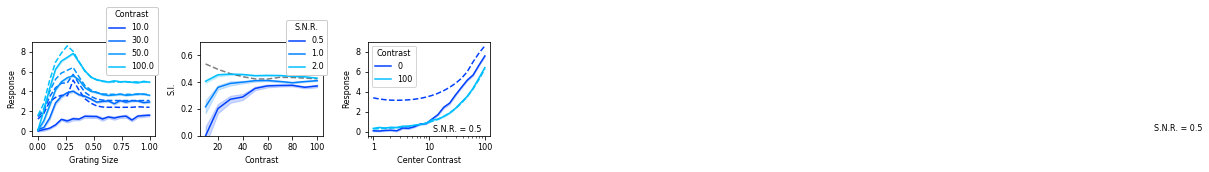

In [867]:
SNR = ["0.5","0.75","1.0","2.0","3.0"]

noisy_size_tuning_V = np.array([np.array(utils.fetch_file("./model_files/MGSM_model_file/TA_responses_0.5_2_{}_size_tuning_1.0.pkl".format(snr))) for snr in SNR])
clean_size_tuning_V = np.array(utils.fetch_file("./model_files/MGSM_model_file/nonoise_responses_0.5_1_1.0_size_tuning_1.0.pkl".format(snr)))
noisy_size_tuning_V.shape

def ST(f):
    return np.reshape(resp(f,meanax = (1,2)),[len(SNR),20,11])

noisy_size_tuning = ST(noisy_size_tuning_V)
noisy_size_tuning_std = boot_f(ST,noisy_size_tuning_V)
clean_size_tuning = np.reshape(resp(clean_size_tuning_V,meanax = (0)),[20,11])

def SI(x):
    y = x/np.max(x)
    
    return 1. - y[-1]

def full_SI(f):
    a = np.reshape(resp(f,meanax = (1,2)),[len(SNR),20,11])
    return np.array([[SI(y) for y in x] for x in np.transpose(a,[0,2,1])])
print(clean_size_tuning[:,1])

noisy_SI = full_SI(noisy_size_tuning_V)
noisy_SI_std = boot_f(full_SI,noisy_size_tuning_V)

clean_SI = np.array([SI(y) for y in np.transpose(clean_size_tuning)])
print(clean_SI)

fig,sub = plt.subplots(1,3,figsize = (twocol,twocol/3))

cc = np.linspace(0,100,len(clean_SI))
ccn = np.linspace(0,100,len(noisy_SI[0]))

stc = np.linspace(0,100,11)

STind = 0
ind = [1,3,5,10]
colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(ind))]
x = np.linspace(0,1,noisy_size_tuning.shape[1])
for i in range(len(ind)):
    sub[0].plot(x,noisy_size_tuning[STind,:,ind[i]],color = colors[i],label = "{}".format(stc[ind[i]]))
    fill_between(sub[0],x,noisy_size_tuning[STind,:,ind[i]],noisy_size_tuning_std[STind,:,ind[i]],color = colors[i])
    sub[0].plot(x,clean_size_tuning[:,ind[i]],"--",color = colors[i])
sub[0].set_xlabel("Grating Size")
sub[0].set_ylabel("Response")
sub[0].text(10,0,"S.N.R. = {}".format(SNR[STind]))
sub[0].legend(loc = (.6,.65),title = "Contrast",framealpha = 1)

sub[1].plot(cc[1:],clean_SI[1:],"--",color = (0,0,0,.5))
SIind = [0,2,3]
colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(SIind))]
for k in range(len(SIind)):
    sub[1].plot(ccn[1:],noisy_SI[SIind[k]][1:],label = "{}".format(SNR[SIind[k]]),color = colors[k])
    fill_between(sub[1],ccn[1:],noisy_SI[SIind[k]][1:],noisy_SI_std[SIind[k]][1:],color = colors[k])
sub[1].legend(loc = (.7,.65),title = "S.N.R.",framealpha = 1)
sub[1].set_ylim([0,.7])
sub[1].set_xlabel("Contrast")
sub[1].set_ylabel("S.I.")

ssSNR = ["0.5","0.75","1.0","2.0"]

def SS(f):
    return np.reshape(resp(f,meanax = (1,2)),[len(ssSNR),20,2])
noisy_surrond_suppression_V = np.array([utils.fetch_file("./model_files/MGSM_model_file/TA_responses_0.5_2_{}_surround_suppression_1.0.pkl".format(s)) for s in ssSNR])
clean_surrond_suppression_V = np.array(utils.fetch_file("./model_files/MGSM_model_file/nonoise_responses_0.5_1_1.0_surround_suppression_1.0.pkl".format(snr)))

noisy_surrond_suppression = SS(noisy_surrond_suppression_V)
noisy_surrond_suppression_std = boot_f(SS,noisy_surrond_suppression_V)
clean_surrond_suppression = np.reshape(resp(clean_surrond_suppression_V,meanax = (0)),[20,2])

c = np.logspace(0,2,clean_surrond_suppression.shape[0])

sub[2].plot(c,clean_surrond_suppression[:,0],"--",color = (0,.25,1,1))
sub[2].plot(c,clean_surrond_suppression[:,1],"--",color = (0,.75,1,1))
sub[2].plot(c,noisy_surrond_suppression[0,:,0],label = "0",color = (0,.25,1,1))
sub[2].plot(c,noisy_surrond_suppression[0,:,1],label = "100",color = (0,.75,1,1))

fill_between(sub[2],c,noisy_surrond_suppression[0,:,0],noisy_surrond_suppression_std[0,:,0],color = (0,.25,1,1))
fill_between(sub[2],c,noisy_surrond_suppression[0,:,1],noisy_surrond_suppression_std[0,:,1],color = (0,.75,1,1))

sub[2].text(12,0,"S.N.R. = {}".format(ssSNR[0]))
sub[2].set_xscale("log")
sub[2].set_xticks([1,10,100])
sub[2].set_xticklabels([1,10,100])
sub[2].legend(title = "Contrast")
sub[2].set_xlabel("Center Contrast")
sub[2].set_ylabel("Response")

plt.tight_layout()
plt.show()